/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of masks: 14
Mask 1 Class: cat Score: 0.813090443611145


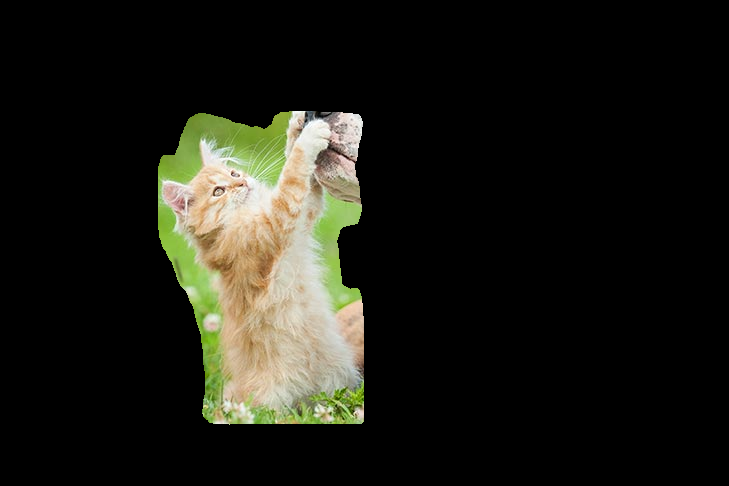

Mask 2 Class: sheep Score: 0.7995381355285645


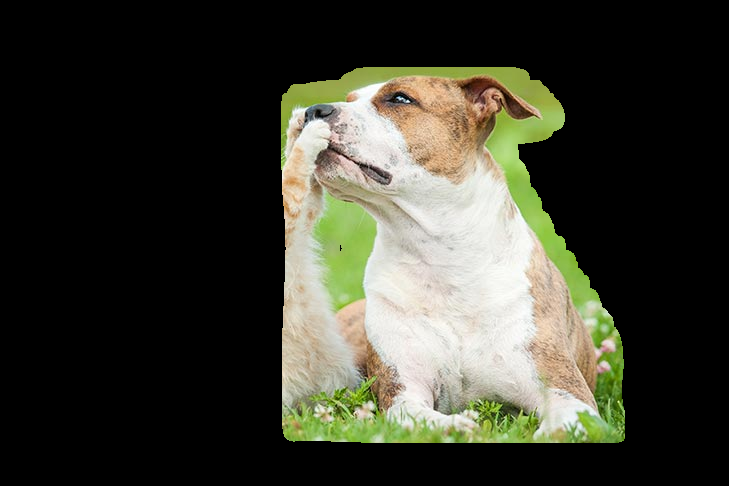

Mask 3 Class: sheep Score: 0.6119446158409119


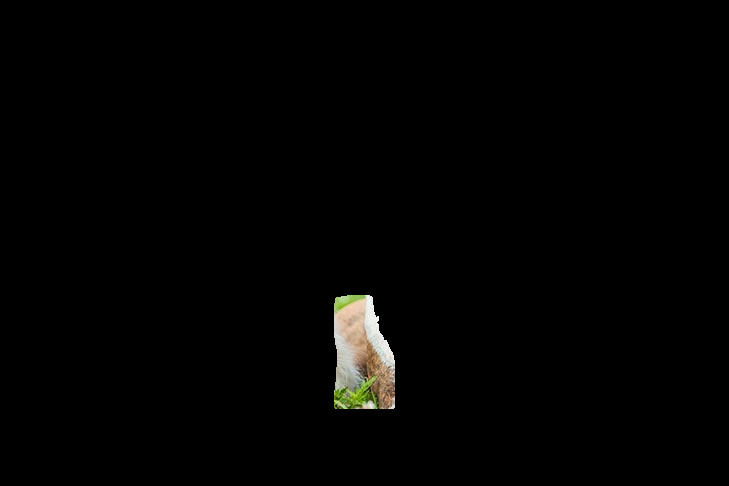

Mask 4 Class: dog Score: 0.5224238038063049


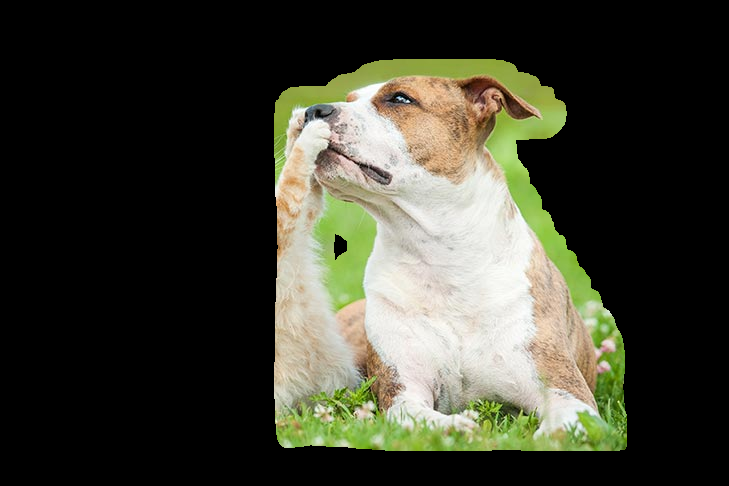

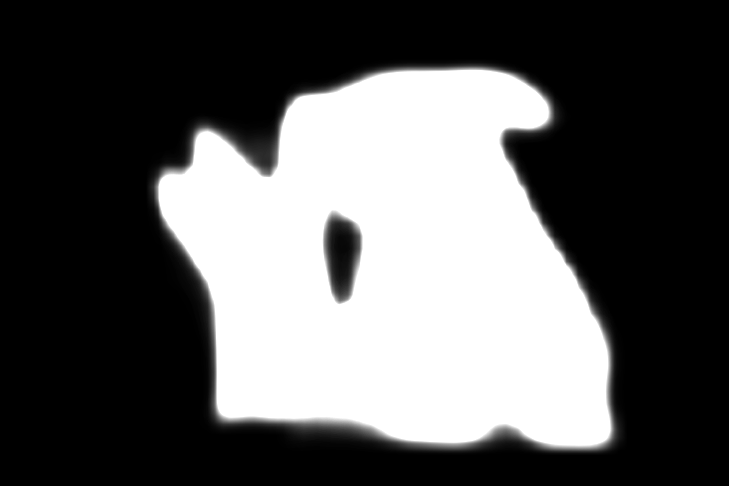

In [8]:
import torch
import torchvision
from torchvision import transforms as T
from PIL import Image
import cv2
import numpy as np
import urllib.request
from google.colab.patches import cv2_imshow

# COCO dataset's class labels
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant',
    'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
    'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
    'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def instance_segmentation(image_path):
    # Pre-trained Mask R-CNN model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model.eval()

    img = Image.open(image_path)

    # Transformations
    transform = T.Compose([T.ToTensor()])
    img_tensor = transform(img)

    # Inference
    with torch.no_grad():
        pred = model([img_tensor])

    # Retrieving masks, labels, and scores
    masks = pred[0]["masks"]
    labels = pred[0]["labels"]
    scores = pred[0]["scores"]

    # The number of masks
    num_masks = masks.shape[0]
    print("Number of masks:", num_masks)

    # Combining masks for visualization
    combined_mask = np.zeros_like(masks[0, 0])
    for i in range(num_masks):
        mask_img = masks[i, 0].mul(255).byte().cpu().numpy()
        combined_mask += mask_img

        # Applying the mask to the original image
        original_img = cv2.imread(image_path)
        masked_img = cv2.bitwise_and(original_img, original_img, mask=mask_img)

        label_idx = labels[i].item()
        score = scores[i].item()

        # For filtering out the unnecessary classes that would be shown otherwise
        if(score < 0.5):
          continue

        # Map label index to class name
        class_name = COCO_INSTANCE_CATEGORY_NAMES[label_idx]

        # Print the label, class name, and score
        print("Mask", i+1, "Class:", class_name, "Score:", score)

        # Display the masked image
        cv2_imshow(masked_img)

    # Display the combined mask
    combined_mask = np.clip(combined_mask, 0, 255).astype(np.uint8)
    cv2_imshow(combined_mask)

# Define the image URL
image_url = "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg"
# For demonstration, I have chosen an image of multiple cars over a highway

# Downloading the image from the URL
urllib.request.urlretrieve(image_url, "input_image.jpg")

# Instance segmentation on the downloaded image
instance_segmentation("input_image.jpg")
